In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

C:\Users\julia\AppData\Local\Temp\ipykernel_26980\984614668.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [12]:
# Best word2vec model so far:
from gensim import downloader as api
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# load data
df = pd.read_csv(r'c:\Users\julia\Desktop\CBS\2. NLP and Text Analytics\Assignments\Final Assignment\news.csv')

# load Word2Vec model
w2v_model = api.load("word2vec-google-news-300")

def preprocess_text(text):
    # tokenization
    tokens = word_tokenize(text)
    # stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# apply function to news column
df['news'] = df['news'].apply(preprocess_text)

def generate_embeddings(text, w2v_model, oov_token='UNK'):
    embedding = []
    for word in text.split():
        if word in w2v_model.key_to_index:
            embedding.append(w2v_model[word])
        else:
            # If word is out of vocabulary, use a special token or vector
            embedding.append(w2v_model[oov_token])
    if not embedding:
        # If the document is empty, return a vector of zeros directly
        return np.zeros(w2v_model.vector_size)
    return np.mean(embedding, axis=0)

# apply the embedding function to the news column
df['embeddings'] = df['news'].apply(lambda x: generate_embeddings(x, w2v_model))

# Create features and labels
X = np.vstack(df['embeddings'].to_numpy())
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# create function to build the models with hyperparameters to tune
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())

    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(
            units=hp.Int(f'layer_{i}_units', min_value=64, max_value=640, step=64),
            activation=hp.Choice('activation', ['relu', 'tanh']),
            # kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log')
                                  ))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='NLP',
    project_name='final_test_2'
)

# Early stopping implemented
early_stopping = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)

# training
tuner.search(
    X_train, y_train, epochs=15, validation_split=0.2, callbacks=[early_stopping]
)

# best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# get and print best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# evaluate the model
loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Reloading Tuner from NLP\final_test_2\tuner0.json
Best Hyperparameters:
{'num_layers': 3, 'layer_0_units': 576, 'activation': 'relu', 'dropout_rate': 0.2, 'layer_1_units': 384, 'learning_rate': 0.0001, 'layer_2_units': 64}


c:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 576)            │       173,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,499 (1.61 MB)

 Trainable params: 420,899 (1.61 MB)

 Non-trainable params: 600 (2.34 KB)

896/896 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7950 - loss: 0.6354
Test Accuracy: 0.7940365076065063


In [14]:
import time

# Best hyperparameters
best_hyperparameters = {
    'num_layers': 3,
    'layer_0_units': 576,
    'activation': 'relu',
    'dropout_rate': 0.2,
    'layer_1_units': 384,
    'learning_rate': 0.0001,
    'layer_2_units': 64
}

# Build the model using the hyperparameters determined from tuning
def build_best_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())  # Batch normalization layer

    for i in range(best_hyperparameters['num_layers']):
        model.add(Dense(
            units=best_hyperparameters[f'layer_{i}_units'],
            activation=best_hyperparameters['activation']
        ))
        model.add(Dropout(best_hyperparameters['dropout_rate']))

    # Output layer with units equal to the number of classes and softmax activation
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for label encoded targets
        metrics=['accuracy']
    )
    return model

best_model = build_best_model()

# get the the model summary
best_model.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Record the start time for training
start_time = time.time()

# train model
history = best_model.fit(
    X_train,
    y_train,
    epochs=30,
    callbacks=[early_stopping],
    validation_split=0.2
)

# Record the end time after training ends
end_time = time.time()

# calculate the total time taken
runtime = end_time - start_time
print(f"Training time: {runtime:.2f} seconds")

# evaluate and print
loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 576)            │       173,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 384)            │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,499 (1.61 MB)

 Trainable params: 420,899 (1.61 MB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5924 - loss: 1.2825 - val_accuracy: 0.7711 - val_loss: 0.7198
Epoch 2/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7387 - loss: 0.8244 - val_accuracy: 0.7795 - val_loss: 0.6854
Epoch 3/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7574 - loss: 0.7691 - val_accuracy: 0.7839 - val_loss: 0.6707
Epoch 4/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7676 - loss: 0.7282 - val_accuracy: 0.7868 - val_loss: 0.6594
Epoch 5/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7732 - loss: 0.6990 - val_accuracy: 0.7899 - val_loss: 0.6482
Epoch 6/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7812 - loss: 0.6756 - val_accuracy: 0.7914 - val_loss: 0.6460
Epoch 7/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7865 - loss: 0.6563 - val_accuracy: 0.7930 - val_loss: 0.6359
Epoch 8/30
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7909 - loss: 0

In [18]:
# use model to make predictions on X_test
predictions = best_model.predict(X_test)

# Evaluate the trained model on the test data (provides accuracy and loss of the test data)
loss, test_accuracy = best_model.evaluate(X_test, y_test)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", loss)

896/896 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7949 - loss: 0.6342
Test Accuracy: 0.7951188683509827
Test Loss: 0.636159360408783


In [19]:
# convert the predictions to category labels
predicted_classes = predictions.argmax(axis=1)

# print the classification report
print(classification_report(y_test, predicted_classes, target_names=label_encoder.classes_))

# print the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

                     precision    recall  f1-score   support

ART & ENTERTAINMENT       0.78      0.77      0.78      4320
    BUSINESS & TECH       0.70      0.60      0.65      1705
        ENVIRONMENT       0.62      0.60      0.61       707
         GASTRONOMY       0.80      0.85      0.83      1643
          PARENTING       0.75      0.76      0.75      2479
           POLITICS       0.86      0.84      0.85      6602
             SPORTS       0.75      0.82      0.78       848
     STYLE & BEAUTY       0.86      0.83      0.85      2240
             TRAVEL       0.77      0.84      0.81      1897
           WELLNESS       0.80      0.82      0.81      4599
         WORLD NEWS       0.73      0.76      0.74      1601

           accuracy                           0.80     28641
          macro avg       0.77      0.77      0.77     28641
       weighted avg       0.80      0.80      0.79     28641

[[3343   47   30   64  143  264   67  148   69  113   32]
 [  66 1030   25   34   

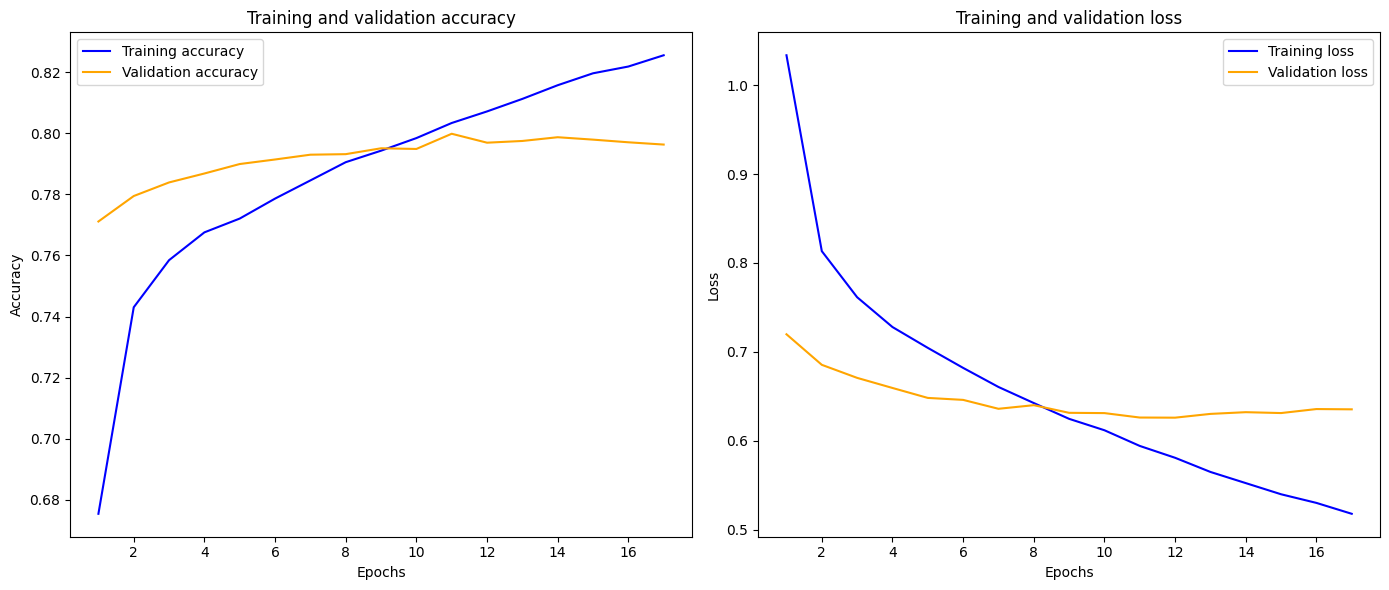

In [20]:
# get accuracy and loss plots:
history_dict = history.history
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

# determine the number of epochs
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))

# plot training and validation accuracy:
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b-", label="Training accuracy")
plt.plot(epochs, val_accuracy, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# plot training and validation loss:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

# save plots
plt.savefig("training_validation_plot_final_2.png")

plt.show()